In [1]:
%run ../setup.py

In [4]:
with pm.Model() as modelss:
    a = pm.Normal('a', mu=0, sd=1)

In [5]:
type(a)

pymc3.model.FreeRV

In [4]:
import lightkurve as lk

# lc = lk.search_lightcurvefile('KIC 11558725', cadence='short', mission='Kepler',quarter=[17]).download_all().stitch()\
lc = lk.search_lightcurvefile('KIC 7668647', cadence='short', mission='Kepler',quarter=[17]).download_all().stitch().remove_nans()

/Users/danielhey/anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:212: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Plotting PDCSAP_FLUX. You can remove this warning by using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)


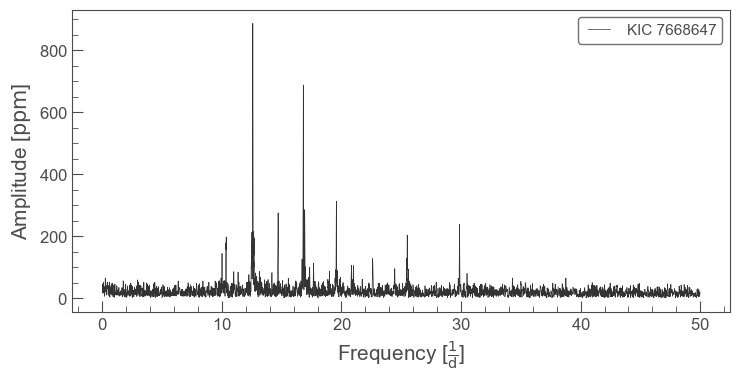

In [6]:
lc.to_periodogram(maximum_frequency=50).plot()

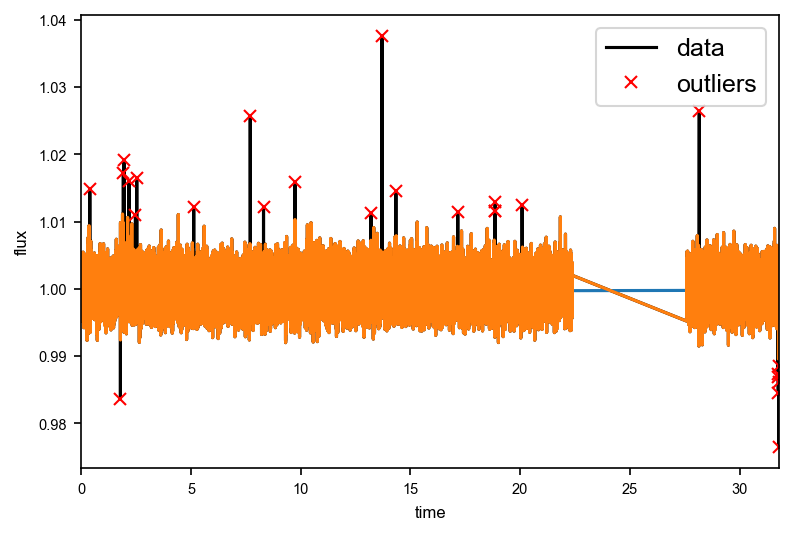

In [7]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

# Convert to parts per million
#df = pd.read_csv('sdb_wd_11558725.csv')
x = lc.time#df['time']
y = lc.flux#df['flux']
mu = np.median(y)
y = (y / mu )# * 1e3
#yerr = lc.flux_err * 1e6

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

# Only discard positive outliers
m = (resid < 5*sigma) & (resid > -5*sigma)

# Shift the data so that the data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

plt.plot(x,y)

In [8]:
freqs = np.array([23.73281177, 27.85623219, 30.24922789])

(0, 50)

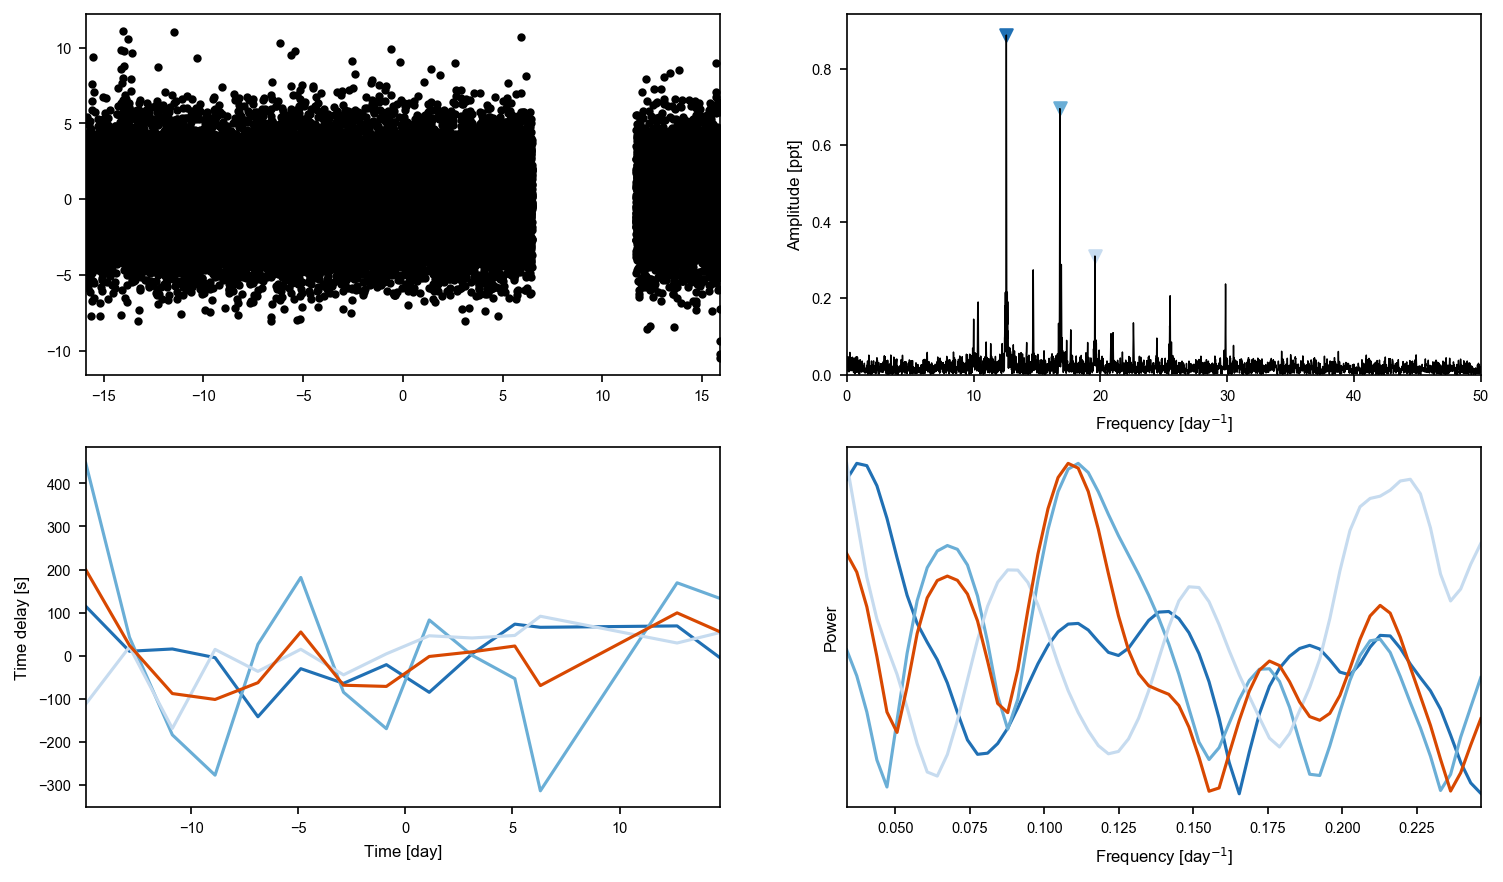

In [9]:
ms = Maelstrom(x, y, max_peaks=3, fmax=50)#freq=freqs)
axes = ms.first_look(segment_size=2)
axes[1].set_xlim(0,50)

In [30]:
from tqdm import tqdm
import theano.tensor as tt

time, mag = ms.time, ms.flux
freq = ms.freq
with pm.Model() as simple_model:
    
    period = pm.Flat("period", testval=10.0)
    nu = pm.Flat("nu", testval=15)
    
    phi = xo.distributions.Angle("phi")
    logasini = pm.Uniform("logasini", lower=np.log(1), upper=np.log(1000),
                          testval=np.log(10))
    drift = pm.Normal("drift", mu=0, sd=1.0)
    
    M = 2.0 * np.pi * time / period - phi
    
    factor = 2. * np.pi * nu
    A = factor * (1 + drift) * time
    B = -factor * (tt.exp(logasini) / 86400) * tt.sin(M)
    
    sinarg = tt.sin(A+B)
    cosarg = tt.cos(A+B)
    
    DT = tt.stack((sinarg, cosarg, tt.ones_like(sinarg)))
    w = tt.slinalg.solve(tt.dot(DT, DT.T), tt.dot(DT, mag))
    pm.Deterministic("w", w)
    pm.Deterministic("phase", tt.arctan2(w[1], w[0]))
    lc_model = tt.dot(DT.T, w)
        
    pm.Normal("obs", mu=lc_model, observed=mag)
    
    fit_params = [v for v in simple_model.vars if v.name not in ["period", "nu"]]

def run_fit(p, nu):
    with simple_model:
        start = dict(simple_model.test_point)
        start["period"] = p
        start["nu"] = nu
        point, info = xo.optimize(start, vars=fit_params, return_info=True, verbose=False)
    return -info.fun, point

#periods = np.exp(np.linspace(np.log(10), np.log(25), 50))
periods = np.linspace(10, 20, 50)
results = []
for f in freq:
    results.append([run_fit(p, f) for p in tqdm(periods)])

100%|██████████| 50/50 [01:50<00:00,  2.46s/it]


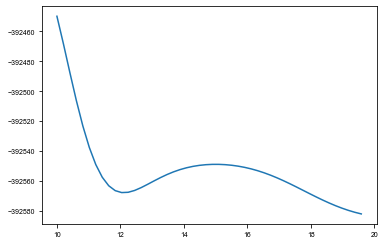

In [31]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);

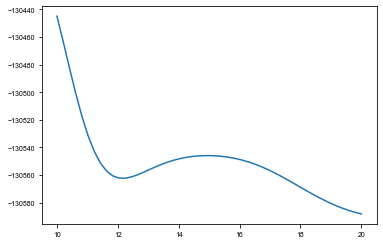

In [32]:
ys = np.array([[r[0] for r in row] for row in results])
plt.plot(periods, ys[1]);

In [ ]:
0, 1, 2, 3

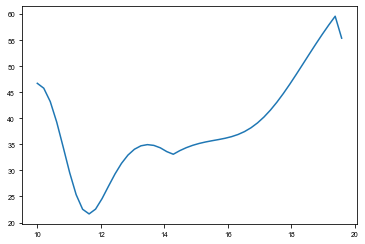

In [33]:
ys = np.array([[np.exp(r[1]["logasini"]) for r in row] for row in results])
sm = np.median(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);

In [25]:
period_guess = 14.2
a_guess = 50.8

time, flux = ms.time, ms.flux
freq = ms.freq
weights = ms.get_weights(norm=False)

No handles with labels found to put in legend.


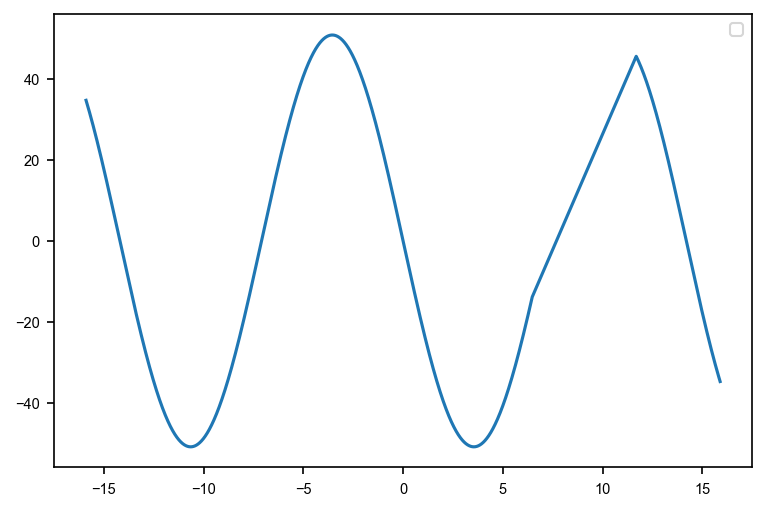

In [26]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano

with_gp = False
with_eccen =True

with pm.Model() as new_model:
    # Period
#     logP = pm.Normal("logP", mu=np.log(period_guess), sd=1, shape=1, testval=np.log(period_guess))
    
    logP = pm.Bound(pm.Normal,
                         lower=np.log(11.5),
                         upper=np.log(20))("logP", mu=np.log(period_guess), sd=1, shape=1, testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    asini = pm.Normal('asini', mu=a_guess, sd=10, testval=a_guess)
    phi = xo.distributions.Angle('phi', testval=0)
    mean = pm.Normal("mean", mu=np.mean(ms.flux), sd=10.0, testval=np.mean(ms.flux))
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.median(np.abs(np.diff(ms.flux)))), sd=1, testval=np.log(np.median(np.abs(np.diff(ms.flux)))))
    sigma = pm.Deterministic('sigma', tt.exp(2*logs_lc))
    #     logs_lc = pm.HalfNormal("logs_lc",  sigma=0.25, testval=0.05)
    M = 2.0 * np.pi * (ms.time) / period - phi
    
    if with_eccen:
        varpi = xo.distributions.Angle('varpi', testval=0)
        eccen = pm.Uniform("ecc", lower=0.0, upper=0.9, testval=0.001)
        f = get_true_anomaly(M, eccen + tt.zeros_like(M))
        psi = -(1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))
    else:
        psi = -tt.sin(M)
        
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    tau = ((asini) / 86400) * psi[:, None]
    arg = 2. * np.pi * nu * (ms.time[:, None] - tau)
    D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
    w = tt.slinalg.solve(tt.dot(D.T, D), tt.dot(D.T, ms.flux))
    pm.Deterministic('w', w)
    lc_model = tt.dot(D, w)
    full_lc = lc_model - mean
    
    if with_gp:
        logw0 = pm.Bound(pm.Normal,
                         lower=np.log(2*np.pi/100.0),
                         upper=np.log(2*np.pi/2))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                    testval=np.log(2*np.pi/10))
        logpower = pm.Normal("logpower", mu=np.log(np.var(ms.flux)), sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, ms.time, tt.exp(2*logs_lc) + tt.zeros(len(ms.time)), J=2)

        pm.Potential("obs", gp.log_likelihood(ms.flux - full_lc))
    else:
        pm.Normal('obs', mu=full_lc, 
                  sd=sigma, 
                  observed=ms.flux)
with new_model:
#     plt.plot(ms.time, ms.tau * 86400, label='Data')
    plt.plot(ms.time, xo.eval_in_model(psi * asini))
    plt.legend()
#     plt.xlim(200,300)

In [27]:
with new_model:
    #map_params = xo.optimize(start=None, vars=[phi, varpi])
#     map_params = xo.optimize(start=None, vars=[logP, asini])
    map_params = xo.optimize(start=None, vars=[mean,logs_lc])
    if with_eccen:
        map_params = xo.optimize(start=map_params, vars=[eccen, varpi])
#     map_params = xo.optimize(start=map_params, vars=[ecosw, esinw])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params)
    
    map_params = xo.optimize(start=map_params, vars=[asini])
    map_params = xo.optimize(start=map_params)

    map_params = xo.optimize(start=map_params, vars=[logP])
    if with_gp:
        map_params = xo.optimize(start=map_params, vars=[logpower, logw0])

optimizing logp for variables: [logs_lc, mean]
17it [00:00, 18.41it/s, logp=-8.393111e+04]
message: Optimization terminated successfully.
logp: -92893.65490070586 -> -83931.11479653954
optimizing logp for variables: [varpi, ecc]
21it [00:00, 34.90it/s, logp=-8.390180e+04]
message: Optimization terminated successfully.
logp: -83931.11479653954 -> -83901.80392084464
optimizing logp for variables: [phi]
11it [00:00, 27.26it/s, logp=-8.388128e+04]
message: Optimization terminated successfully.
logp: -83901.80392084464 -> -83881.27656854957
optimizing logp for variables: [lognu]
17it [00:00, 31.79it/s, logp=-8.388110e+04]
message: Optimization terminated successfully.
logp: -83881.27656854957 -> -83881.09569364492
optimizing logp for variables: [lognu, ecc, varpi, logs_lc, mean, phi, asini, logP]
196it [00:05, 37.11it/s, logp=-8.388074e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -83881.09569364492 -> -83880.74284073661
optimizing logp for variables: [as

In [28]:
map_params

{'logP_interval__': array([-0.49801004]),
 'asini': array(54.48114339),
 'phi_angle__': array([1.77880752, 4.10315002]),
 'mean': array(-0.00119793),
 'logs_lc': array(0.37397822),
 'varpi_angle__': array([-2.31283962,  3.82763511]),
 'ecc_interval__': array(0.47816286),
 'lognu': array([2.53261735, 2.8220997 , 2.97420969]),
 'logP': array([2.65153132]),
 'period': array([14.17572961]),
 'phi': array(0.40906701),
 'sigma': array(2.11267823),
 'varpi': array(-0.54353694),
 'ecc': array(0.55558257),
 'nu': array([12.58640614, 16.81211404, 19.5741474 ]),
 'w': array([-0.55920306,  0.29476991, -0.22289564, -0.69138785, -0.63283725,
         0.21270192])}

In [29]:
sampler = xo.PyMC3Sampler(window=200, finish=500)
with new_model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 2 chains: 100%|██████████| 1004/1004 [08:36<00:00,  1.94draws/s]


In [30]:
with new_model:
    trace = sampler.sample(draws=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lognu, ecc, varpi, logs_lc, mean, phi, asini, logP]
Sampling 2 chains: 100%|██████████| 2000/2000 [12:20<00:00,  2.70draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [31]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
asini,52.615849,8.607546,1.994273e-01,35.787247,69.093283,1951.487933,0.999696
mean,-0.000908,0.010509,2.570975e-04,-0.022872,0.019315,1959.675496,1.001047
logs_lc,0.374046,0.001811,4.081673e-05,0.370361,0.377326,2065.354556,1.000377
lognu__0,2.532612,0.000025,6.840784e-07,2.532564,2.532661,1446.328011,0.999712
lognu__1,2.822099,0.000026,7.771582e-07,2.822049,2.822151,1192.392597,0.999531
lognu__2,2.974205,0.000044,1.025679e-06,2.974121,2.974288,2192.327001,0.999714
logP__0,2.699771,0.119626,5.661498e-03,2.442951,2.899252,298.666272,1.000026
period__0,14.982730,1.786674,8.218069e-02,11.506953,18.160547,348.546205,1.000032
phi,0.588239,1.859861,8.196647e-02,-2.991525,2.979499,445.131399,1.000182
sigma,2.112980,0.007650,1.724314e-04,2.097451,2.126871,2065.118440,1.000377


In [33]:
pm.save_trace(trace, 'traces/7668647_ABSOLUTE_FINAL')

'traces/7668647_ABSOLUTE_FINAL'

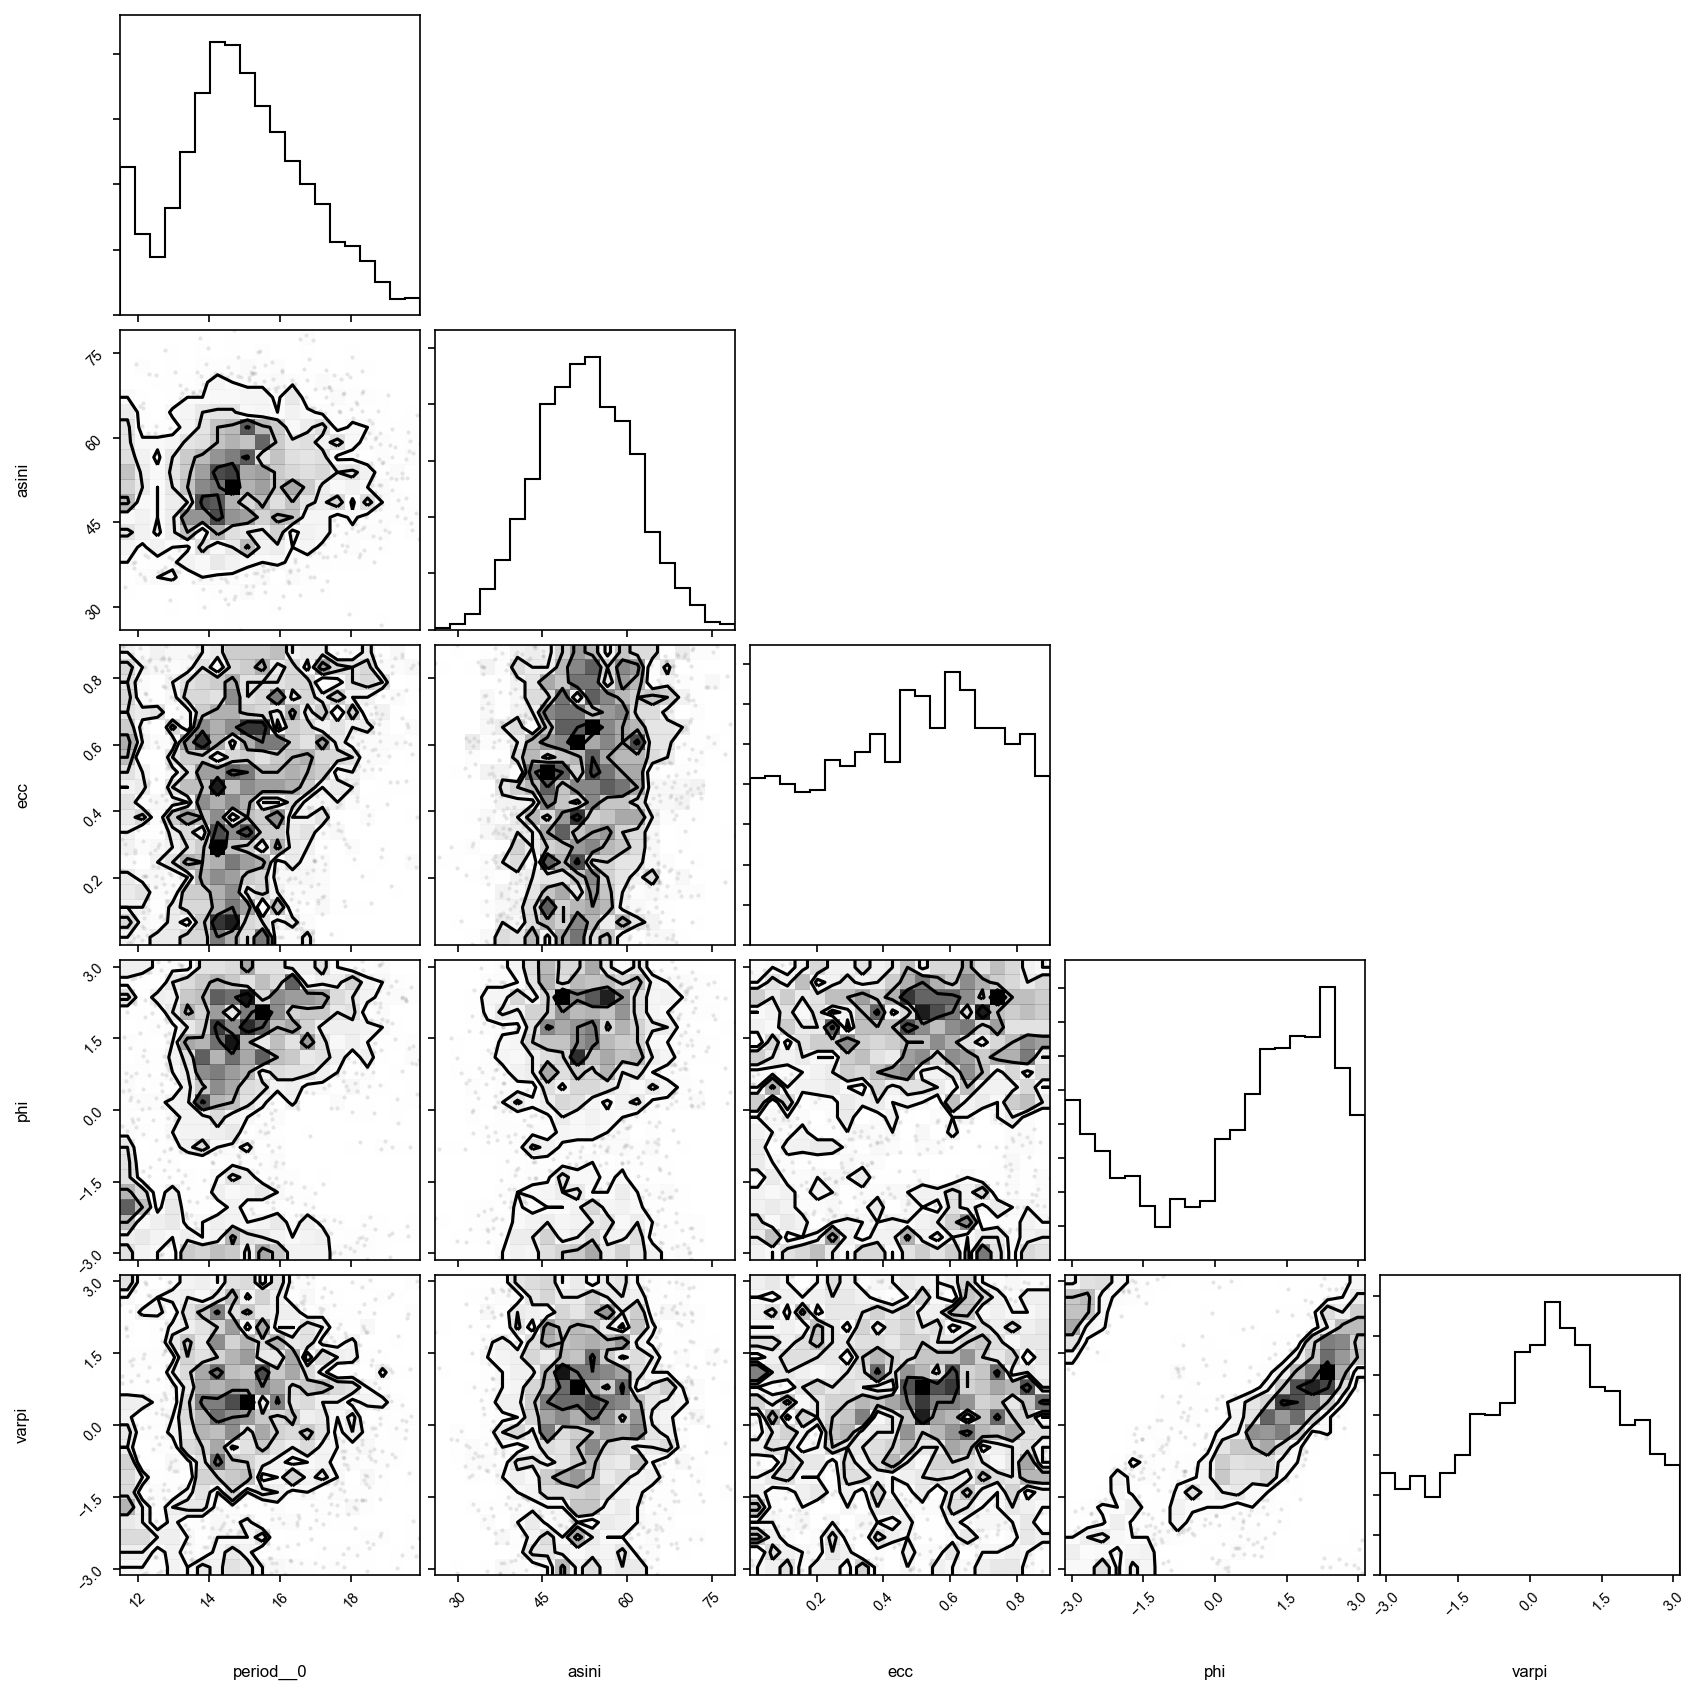

In [32]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=['period', 'asini', 'ecc', 'phi', 'varpi']));

In [19]:

varnames=['period', 'asini', 'phi', 'ecc', 'varpi']
rounding = 4
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  14.0017  +  1.534  -  2.6417
asini :  51.0128  +  8.5866  -  8.7842
phi :  0.1386  +  2.067  -  2.3374
ecc :  0.0491  +  0.0345  -  0.0327
varpi :  0.2368  +  1.9539  -  2.3157


In [20]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
mfs = mass_function(samples['period__0'].values * u.day, samples['asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.739  +  0.581  -  0.335


In [66]:
samples

,period__0,asini
0,9.202383,41.167538
1,9.342918,41.913377
2,9.168847,51.849477
3,9.574080,61.753780
4,9.578831,32.100304
...,...,...
1995,8.707824,50.702067
1996,8.770516,43.902311
1997,9.323842,56.676692
1998,9.498864,42.538489


In [18]:
pm.save_trace(trace, 'traces/7668647_final_constrained_e')

'traces/7668647_final_constrained_e'